In [1]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set()



u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')

In [2]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))

q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweeky3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]

q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})

#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

In [3]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [19]:
d = cDict['vsc'].copy()
d = d[d['rt'] >= 200]
d = d[d['rt'] <= 15000]
d.loc[d["attempt"] == 0,'rt'] = np.nan

d_allY = d[(d['condition'] == d['condition'].unique()[0])]
dY = d[(d['condition'] == d['condition'].unique()[1])]
d_3Y = d[(d['condition'] == d['condition'].unique()[2])]

#### Grupy a średni czas potrzebny na znalezienie Y

In [39]:
desc1 = dY.groupby(['id','group']).agg(
    rt = pd.NamedAgg(column='rt', aggfunc=np.mean)).reset_index()

In [41]:
pg.homoscedasticity(desc1, group='group', dv='rt')

,W,pval,equal_var
levene,1.381785,0.259413,True


In [42]:
aov = pg.anova(dv='rt', between='group', data=desc1,
               detailed=True).round(3)

In [43]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,5.547467e+07,2,2.773733e+07,8.764,0.0,0.235
1,Within,1.804014e+08,57,3.164936e+06,NaN,NaN,NaN


In [44]:
pg.pairwise_ttests(data=desc1, dv='rt', between='group', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,LoL,Praca,5026.859,1796.699,6868.116,2123.468,False,True,-2.960,38.0,two-sided,0.005,0.016,sidak,8.169,-0.918
1,group,LoL,CS:GO,5026.859,1796.699,4675.508,1325.733,False,True,0.704,38.0,two-sided,0.486,0.864,sidak,0.376,0.218
2,group,Praca,CS:GO,6868.116,2123.468,4675.508,1325.733,False,True,3.917,38.0,two-sided,0.000,0.001,sidak,72.739,1.214


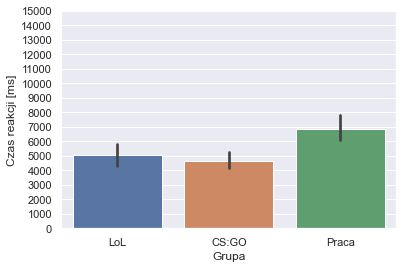

In [55]:
g = sns.barplot(data=desc1,x='group',y='rt',order=['LoL',"CS:GO","Praca"])
g.set(xlabel='Grupa',ylabel='Czas reakcji [ms]')
g.set(yticks=range(0,15001,1000))
plt.show()

Wynik ANOVY okazał się istotny statystycznie, występują między grupami różnice w czasie potrzebnym na znalezienie jednego Y. Grupy LoL i CS:GO nie różnią się od siebie. Grupa pracująca ma dłuższe czasy od grup grających.

In [56]:
d_3y_stat1 = d_3Y.groupby(['attempt']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()
d_3y_stat1['perc'] = d_3y_stat1['n']/60
d_3y_stat1['attempt'] = d_3y_stat1['attempt'].astype(int)

### % badanych który znalazł 1/2/3 Y

In [57]:
d_3y_stat1

,attempt,n,perc
0,1,60.0,1.000000
1,2,59.0,0.983333
2,3,47.0,0.783333


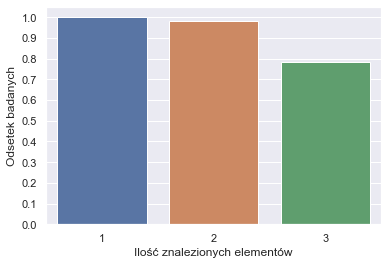

In [60]:
g = sns.barplot(data=d_3y_stat1,x='attempt',y='perc')
g.set(xlabel='Ilość znalezionych elementów',ylabel='Odsetek badanych')
g.set(yticks=np.arange(0,1.1,.1))
plt.show()

### ANOVA - porównanie grup - ile Y udało się znaleźć

In [67]:
yfound = d_allY.groupby(['id','group']).agg(
    n = pd.NamedAgg(column='attempt', aggfunc=np.max)).reset_index()

In [69]:
pg.homoscedasticity(yfound, group='group', dv='n')

,W,pval,equal_var
levene,1.654066,0.200318,True


In [70]:
aov = pg.anova(dv='n', between='group', data=yfound,
               detailed=True).round(3)

In [71]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.733,2,1.867,2.013,0.143,0.066
1,Within,52.850,57,0.927,NaN,NaN,NaN


Wynik wyszedł nieistotny statystycznie, nie występują różnice między grupami w zakresie liczby znalezionych elementów

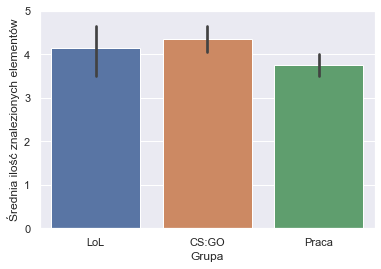

In [73]:
g = sns.barplot(data=yfound,x='group',y='n',order=['LoL',"CS:GO","Praca"])
g.set(xlabel='Grupa',ylabel='Średnia ilość znalezionych elementów')
g.set(yticks=np.arange(0,5.1,1))
plt.show()